# Statistical Modelling

Statistical modeling is the use of mathematical models and statistical assumptions to generate sample data and make predictions about the real world. A statistical model is a collection of probability distributions on a set of all possible outcomes of an experiment.

In [1]:
# Imports 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import time
%matplotlib inline
from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.formula.api import glm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

## Import and Merge Data

In [2]:
# Import processed taxi data 
daily_20 = pd.read_csv("../processed_data/daily_summary_2020.csv").iloc[: , 1:]
daily_20['pickup_date'] = pd.to_datetime(daily_20['pickup_date'])
daily_20.drop(daily_20.columns[[2, 3, 4]], axis = 1, inplace = True) ## drop irrelevant columns
daily_20

,pickup_date,trip_count_k
0,2020-01-01,161.87
1,2020-01-02,153.89
2,2020-01-03,174.74
3,2020-01-04,175.22
4,2020-01-05,156.58
...,...,...
361,2020-12-27,22.82
362,2020-12-28,35.69
363,2020-12-29,40.19
364,2020-12-30,41.67


In [3]:
# Import covid data of 2020
covid_20 = pd.read_csv("../processed_data/covid_2020.csv").iloc[: , 1:]
covid_20['date_of_interest'] = pd.to_datetime(covid_20['date_of_interest'])
covid_20.drop(covid_20.iloc[:, 4:], axis = 1, inplace = True) ## drop irrelevant columns
covid_20

,date_of_interest,CASE_COUNT,DEATH_COUNT,HOSPITALIZED_COUNT
0,2020-02-29,1,0,1
1,2020-03-01,0,0,1
2,2020-03-02,0,0,2
3,2020-03-03,1,0,7
4,2020-03-04,5,0,2
...,...,...,...,...
302,2020-12-27,2886,44,244
303,2020-12-28,5385,43,346
304,2020-12-29,5201,50,320
305,2020-12-30,4976,40,318


In [4]:
# import 2020 weather data
path = "../raw_data/weather"
all_20 = glob.glob(os.path.join(path,"weather_2020-*.csv"))
weather_20 = pd.concat((pd.read_csv(f, parse_dates=[1]) for f in all_20), ignore_index=True).drop("STATION", axis=1)
weather_20["DATE"] = pd.to_datetime(weather_20["DATE"])
weather_20.drop(weather_20.iloc[:, 1:3], axis = 1, inplace = True) ## drop irrelevant columns
weather_20

,DATE,TMAX,TMIN
0,2020-01-01,5.0,1.1
1,2020-01-02,9.4,0.6
2,2020-01-03,9.4,6.7
3,2020-01-04,10.6,5.0
4,2020-01-05,5.6,1.7
...,...,...,...
360,2020-12-27,2.8,-4.3
361,2020-12-28,10.0,1.7
362,2020-12-29,6.1,-1.0
363,2020-12-30,6.1,-2.1


In [5]:
# import ridership data 
raw = pd.read_csv("../raw_data/MTA_recent_ridership_data.csv")
ridership_20 = raw.iloc[217:]
ridership_20['Date'] = pd.to_datetime(ridership_20['Date'])
ridership_20.sort_values(by=['Date'], inplace = True)
ridership_20.drop(ridership_20.iloc[:, 4:9], axis = 1, inplace = True) ## drop irrelevant columns
ridership_20.drop(ridership_20.columns[[2, 5, 7]], axis = 1, inplace = True)## drop irrelevant columns
ridership_20.columns = ['Date', 'Subways', 'Buses', 'Access_a_ride', 'Bridges_n_Tunnels']

In [6]:
## Merge datasets 
merge_20 = pd.merge(daily_20, weather_20, left_on="pickup_date", right_on="DATE").drop(["DATE"], axis=1)
merge_20 = pd.merge(merge_20, covid_20, left_on="pickup_date", right_on=\
                    "date_of_interest").drop(["date_of_interest"], axis=1)
merge_20 = pd.merge(merge_20, ridership_20, left_on="pickup_date", right_on=\
                    "Date").drop(["Date"], axis=1)

In [7]:
# adding a categorical feature - day of a week 
merge_20['day_of_week'] = merge_20['pickup_date'].dt.day_name()
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cat_type = CategoricalDtype(categories=cats, ordered=True)
merge_20['day_of_week'] = merge_20['day_of_week'].astype(cat_type)

In [8]:
merge_20

,pickup_date,trip_count_k,TMAX,TMIN,CASE_COUNT,DEATH_COUNT,HOSPITALIZED_COUNT,Subways,Buses,Access_a_ride,Bridges_n_Tunnels,day_of_week
0,2020-03-01,170.50,6.7,-3.8,0,0,1,2214601,984900,19922,786961,Sunday
1,2020-03-02,183.78,14.4,4.4,0,0,2,5347055,2209100,30338,874620,Monday
2,2020-03-03,212.02,15.0,9.4,1,0,7,5498556,2228600,32767,882175,Tuesday
3,2020-03-04,218.36,13.3,7.2,5,0,2,5515945,2177200,34297,905558,Wednesday
4,2020-03-05,232.68,10.6,3.9,3,0,14,5513656,2244500,33209,929298,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2020-12-27,22.82,2.8,-4.3,2886,44,244,761251,469973,9457,594862,Sunday
302,2020-12-28,35.69,10.0,1.7,5385,43,346,1513195,902574,18820,743305,Monday
303,2020-12-29,40.19,6.1,-1.0,5201,50,320,1558295,918291,19717,759864,Tuesday
304,2020-12-30,41.67,6.1,-2.1,4976,40,318,1585476,935138,20922,799839,Wednesday


In [9]:
# exports 
merge_20.to_csv('../processed_data/modelling_data_2020.csv',header=True)

## Correlation Heatmap

## Poisson Regression Model 

In [10]:
df = merge_20.drop(merge_20.columns[[0]], axis = 1, inplace = False) ## drop datatime data

In [11]:
df.dtypes

trip_count_k           float64
TMAX                   float64
TMIN                   float64
CASE_COUNT               int64
DEATH_COUNT              int64
HOSPITALIZED_COUNT       int64
Subways                  int64
Buses                    int64
Access_a_ride            int64
Bridges_n_Tunnels        int64
day_of_week           category
dtype: object

In [12]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date

# train test split
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=247
Testing data set length=59


In [13]:
expr = """trip_count_k ~ TMAX + TMIN + CASE_COUNT + DEATH_COUNT + HOSPITALIZED_COUNT + Subways + Buses +\
Access_a_ride + Bridges_n_Tunnels + day_of_week"""

In [14]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date
y_train, X_train = dmatrices(expr, df_train, return_type = 'dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type = 'dataframe')

In [15]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date
poisson_fit = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit()
print(poisson_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           trip_count_k   No. Observations:                  247
Model:                            GLM   Df Residuals:                      231
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1038.2
Date:                Mon, 16 Aug 2021   Deviance:                       8.4339
Time:                        19:50:28   Pearson chi2:                     9.46
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Overdispersion check

The Pearson statistic provides an estimate of the data’s dispersion. When the data is drawn from a Poisson distribution with sufficient samples the ratio Pearson chi2 / Df Residuals is approximately 1; for observed data a ratio less than 1 implies underdispersion and more than 1 implies overdispersion. Data that is underdispersed requires a zero-inflated model, which is not directly implemented by Statsmodels.

In [17]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date
poisson_predictions = poisson_fit.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame() #summary_frame() returns a pandas DataFrame
print(predictions_summary_frame)

           mean    mean_se  mean_ci_lower  mean_ci_upper
10   185.117919  63.944301      94.063780     364.312853
13    36.377554   7.980734      23.664188      55.921060
19    17.159668   7.132140       7.598374      38.752267
27     8.813917   3.179125       4.346562      17.872777
30     9.597036   3.702664       4.505389      20.442875
39     5.591609   1.781052       2.995091      10.439110
43     5.019923   1.920798       2.371361      10.626654
56     5.966541   1.864818       3.233577      11.009362
57     7.156192   2.038350       4.094757      12.506502
64     7.668845   1.963473       4.642958      12.666750
82    12.565785   2.935536       7.949458      19.862857
115   18.322287   3.793442      12.210884      27.492376
120   20.168860   4.578071      12.926162      31.469737
125   12.989322   3.301485       7.892913      21.376454
127   19.021391   4.793579      11.607296      31.171198
130   24.466954   5.063423      16.308883      36.705876
133   17.076351   3.870627     

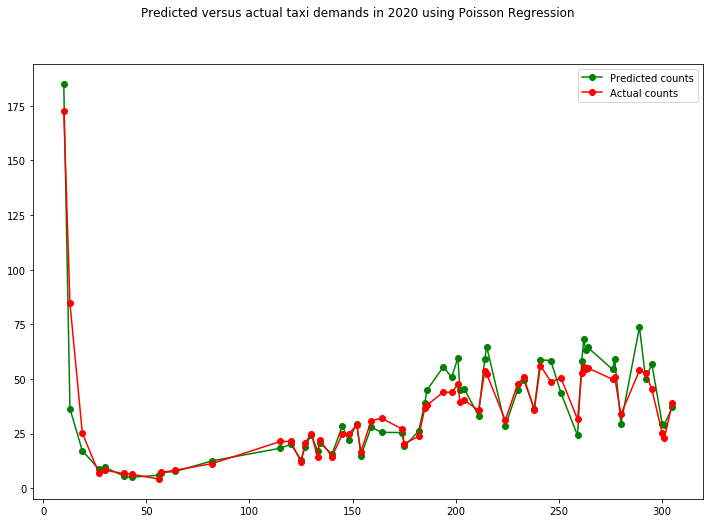

In [18]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['trip_count_k']
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Predicted versus actual taxi demands in 2020 using Poisson Regression')
plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend()
plt.show()
fig.savefig('../plots/Poisson_prediction.png')

In [ ]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['trip_count_k']
fig = plt.figure(figsize = (12, 8))
fig.suptitle('Predicted versus actual taxi demands in 2020 using Poisson Regression')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('../plots/Poisson_prediction.png')

In [ ]:
# Attributs:https://timeseriesreasoning.com/contents/poisson-regression-model/
# Author: Sachin Date

plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

## Nagative Binomial Regression

In [19]:
# Attributs:https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
# Author: Sachin Date

df = merge_20.drop(merge_20.columns[[0]], axis = 1, inplace = False) ## drop datatime data
# train test split
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
# expression
expr = """trip_count_k ~ TMAX + TMIN + CASE_COUNT + DEATH_COUNT + HOSPITALIZED_COUNT + Subways + Buses +\
Access_a_ride + Bridges_n_Tunnels + day_of_week"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
# Regression
nb_fit = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 1)).fit()
print(nb_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           trip_count_k   No. Observations:                  234
Model:                            GLM   Df Residuals:                      218
Model Family:        NegativeBinomial   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -989.41
Date:                Mon, 16 Aug 2021   Deviance:                       8.3306
Time:                        19:50:59   Pearson chi2:                     9.78
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [20]:
# Attributs:https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
# Author: Sachin Date

nb_predict = nb_fit.get_prediction(X_train)
nb_summary_frame_train = nb_predict.summary_frame()
print(nb_summary_frame_train)

           mean     mean_se  mean_ci_lower  mean_ci_upper
1    203.802467   83.999666      90.860761     457.132928
2    246.789155   99.459003     112.016395     543.714040
3    287.646916  113.917680     132.359707     625.120368
4    296.650671  118.208316     135.850593     647.782380
5    272.042635  110.622375     122.604846     603.623736
..          ...         ...            ...            ...
299   13.717711    5.922356       5.885616      31.972118
301   27.468336    7.678123      15.881777      47.507874
302   42.812948   17.574383      19.149768      95.716488
303   48.288465   17.679545      23.561256      98.966530
305   36.906283    9.183790      22.661393      60.105471

[234 rows x 4 columns]


In [21]:
predicted_counts_train = nb_summary_frame_train['mean']

In [22]:
# Accuracy of the train set
print("R-square of train set: ", round(r2_score(y_train, predicted_counts_train)*100, 2), "%")

R-square of train set:  91.97 %


In [23]:
# Attributs:https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
# Author: Sachin Date

nb_predict = nb_fit.get_prediction(X_test)
nb_summary_frame_test = nb_predict.summary_frame()
print(nb_summary_frame_test)
predicted_counts = nb_summary_frame_test['mean']

           mean    mean_se  mean_ci_lower  mean_ci_upper
0     93.124113  33.369489      46.136869     187.964649
6     97.208840  31.350917      51.663513     182.905849
12   100.504899  31.907146      53.945783     187.247903
15    54.187088  13.933521      32.735588      89.695668
18    24.647715   7.787398      13.269091      45.783834
..          ...        ...            ...            ...
292   46.928970  14.535434      25.573850      86.116413
294   25.457227   6.453038      15.489730      41.838716
295   56.588927  17.950757      30.389186     105.376521
300   29.014686   9.191543      15.594315      53.984546
304   54.164564  19.473767      26.772138     109.584076

[72 rows x 4 columns]


In [24]:
#Accuracy of the test set
print("R-square of train set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

R-square of train set:  75.67 %


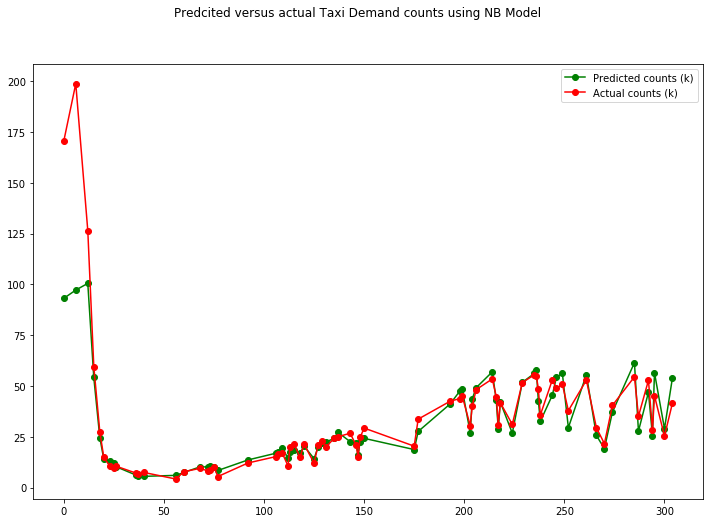

In [25]:
# Attributs:https://timeseriesreasoning.com/contents/negative-binomial-regression-model/
# Author: Sachin Date

fig = plt.figure(figsize = (12, 8))
fig.suptitle('Predcited versus actual Taxi Demand counts using NB Model')
plt.plot(X_test.index, predicted_counts , 'go-', label = 'Predicted counts (k)')
plt.plot(X_test.index, y_test , 'ro-', label = 'Actual counts (k)')
plt.legend()
plt.show()
fig.savefig('../plots/Negative_Binomial_prediction.png')

In [26]:
merge_20

,pickup_date,trip_count_k,TMAX,TMIN,CASE_COUNT,DEATH_COUNT,HOSPITALIZED_COUNT,Subways,Buses,Access_a_ride,Bridges_n_Tunnels,day_of_week
0,2020-03-01,170.50,6.7,-3.8,0,0,1,2214601,984900,19922,786961,Sunday
1,2020-03-02,183.78,14.4,4.4,0,0,2,5347055,2209100,30338,874620,Monday
2,2020-03-03,212.02,15.0,9.4,1,0,7,5498556,2228600,32767,882175,Tuesday
3,2020-03-04,218.36,13.3,7.2,5,0,2,5515945,2177200,34297,905558,Wednesday
4,2020-03-05,232.68,10.6,3.9,3,0,14,5513656,2244500,33209,929298,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
301,2020-12-27,22.82,2.8,-4.3,2886,44,244,761251,469973,9457,594862,Sunday
302,2020-12-28,35.69,10.0,1.7,5385,43,346,1513195,902574,18820,743305,Monday
303,2020-12-29,40.19,6.1,-1.0,5201,50,320,1558295,918291,19717,759864,Tuesday
304,2020-12-30,41.67,6.1,-2.1,4976,40,318,1585476,935138,20922,799839,Wednesday


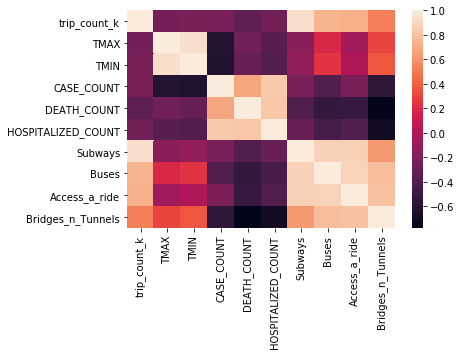

In [30]:
df = merge_20.drop(merge_20.columns[[0]], axis = 1, inplace = False)
svm = sns.heatmap(df.corr())
figure = svm.get_figure()    
figure.savefig('../plots/heatmap.png', dpi=400)